In [1]:
import os
import sys

# This is to force the path to be on the same level as the dl_ba folder
sys.path.append("../..")

from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from balm import common_utils
from balm.models.utils import load_trained_model, load_pretrained_pkd_bounds
from balm.configs import Configs
from balm.models import BALM

DEVICE = "cpu"

/Users/aryopg/miniconda3/envs/dl_ba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Pretrained BindingDB BALM

In [2]:
config_filepath = "../../default_configs/balm_peft.yaml"
configs = Configs(**common_utils.load_yaml(config_filepath))

# Load the model
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=False)
model.to(DEVICE)
model.eval()
# Pretrained pKd lower and upper bounds
pkd_lower_bound, pkd_upper_bound = load_pretrained_pkd_bounds(configs.model_configs.checkpoint_path)

# Load the tokenizers
protein_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.protein_model_name_or_path
)
drug_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.drug_model_name_or_path
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.08605752527901195
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.062120952994882
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse
Merging protein model with its adapter
Merging drug model with its adapter


## Check if the loading is correct, the model should be able to perform well in BindingDB dataset

In [8]:
import time

# Take just 10 data
bindingdb_samples = load_dataset("BALM/BALM-benchmark", "BindingDB_filtered", split="train[:100]")

# Let's time it! Note: This is not a batched prediction!
start = time.time()
predictions = []
labels = []
for sample in bindingdb_samples:
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for 100 protein-ligand pairs: {time.time() - start}")

Cosine similarity: 0.7144517302513123
Predicted pKd: 8.857807159423828 | True pKd: 9.251811981201172
Cosine similarity: 0.7312068939208984
Predicted pKd: 8.924827575683594 | True pKd: 9.229147911071777
Cosine similarity: 0.6613336801528931
Predicted pKd: 8.645334243774414 | True pKd: 9.031517028808594
Cosine similarity: 0.7064732313156128
Predicted pKd: 8.82589340209961 | True pKd: 9.522878646850586
Cosine similarity: 0.7327780723571777
Predicted pKd: 8.931112289428711 | True pKd: 9.585026741027832
Cosine similarity: 0.7481108903884888
Predicted pKd: 8.992443084716797 | True pKd: 9.376750946044922
Cosine similarity: 0.6758778095245361
Predicted pKd: 8.703511238098145 | True pKd: 9.638272285461426
Cosine similarity: 0.7235785722732544
Predicted pKd: 8.89431381225586 | True pKd: 9.698969841003418
Cosine similarity: 0.7042303681373596
Predicted pKd: 8.81692123413086 | True pKd: 9.698969841003418
Cosine similarity: 0.7042303681373596
Predicted pKd: 8.81692123413086 | True pKd: 8.7447271347

Text(0, 0.5, 'Predicted pKd')

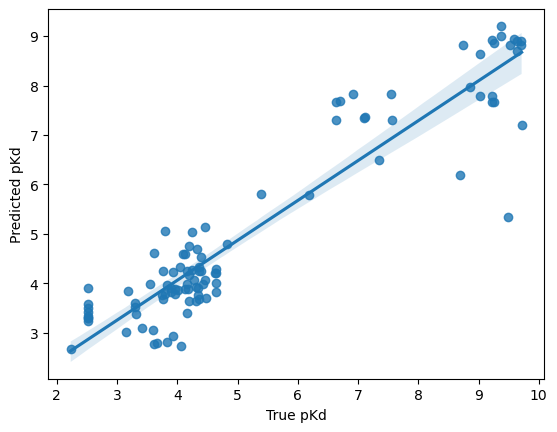

In [10]:
import seaborn as sns

ax = sns.regplot(x=labels, y=predictions)
ax.set_xlabel("True pKd")
ax.set_ylabel("Predicted pKd")

# Zero-shot on new Target (SYK)

In [11]:
# Note: train split is just because it's the default split for the dataset
syk_data = load_dataset("BALM/BALM-benchmark", "SYK", split="train")

Generating train split: 100%|██████████| 44/44 [00:00<00:00, 100.84 examples/s]


In [12]:
start = time.time()
for sample in syk_data:
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for 100 protein-ligand pairs: {time.time() - start}")

Predicted pKd: 5.818968772888184 | True pKd: 7.752026557922363
Predicted pKd: 6.0076518058776855 | True pKd: 7.187086582183838
Predicted pKd: 5.964358329772949 | True pKd: 9.07572078704834
Predicted pKd: 6.037625789642334 | True pKd: 7.8181562423706055
Predicted pKd: 5.947612762451172 | True pKd: 8.050609588623047
Predicted pKd: 5.88356876373291 | True pKd: 8.585026741027832
Predicted pKd: 6.11812686920166 | True pKd: 8.366531372070312
Predicted pKd: 5.98499870300293 | True pKd: 8.657577514648438
Predicted pKd: 6.406008243560791 | True pKd: 8.823908805847168
Predicted pKd: 5.928587436676025 | True pKd: 7.782516002655029
Predicted pKd: 5.993487358093262 | True pKd: 7.931814193725586
Predicted pKd: 6.077610969543457 | True pKd: 7.958607196807861
Predicted pKd: 5.835335731506348 | True pKd: 7.567030906677246
Predicted pKd: 5.921706199645996 | True pKd: 7.2992963790893555
Predicted pKd: 6.075243949890137 | True pKd: 7.171985149383545
Predicted pKd: 6.079503059387207 | True pKd: 7.548213481

RMSE: 1.4789866209030151
Pearson: 0.8522670269012451
Spearman: 0.8491755630925246
CI: 0.8173471093177795


Text(0, 0.5, 'Predicted pKd')

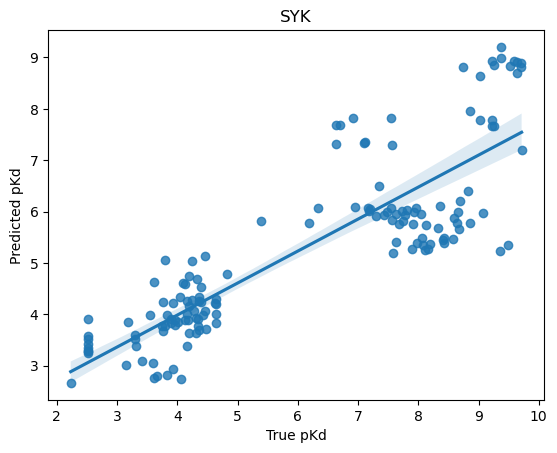

In [21]:
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"SYK")
ax.set_xlabel("True pKd")
ax.set_ylabel("Predicted pKd")

# Few shot training

Note: This is a simplified training process, for a more tested approach, please refer to our `balm/trainer.py`

In [32]:
# Split data
train_test_split = syk_data.train_test_split(train_size=0.2, seed=1234)

train_syk_data = train_test_split["train"]
test_syk_data = train_test_split["test"]

In [44]:
# Define a function that applies the cosine similarity conversion to a single example
# This is VERY IMPORTANT since BALM uses cosine similarity
def add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):
    example['cosine_similarity'] = (
        (example['Y'] - pkd_lower_bound)
        / (pkd_upper_bound - pkd_lower_bound)
        * 2
        - 1
    )
    return example

# Use map to apply the function across the entire dataset
train_syk_data = train_syk_data.map(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound))
test_syk_data = test_syk_data.map(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound))

Map: 100%|██████████| 36/36 [00:00<00:00, 2621.03 examples/s]


In [46]:
print(f"Number of train data: {len(train_syk_data)}")
print(f"Number of test data: {len(test_syk_data)}")

Number of train data: 8
Number of test data: 36


In [53]:
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=True)
model = model.to(DEVICE)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.08605752527901195
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.062120952994882
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse
Merging protein model with its adapter
Merging drug model with its adapter
protein_projection.weight
protein_projection.bias
drug_projection.weight
drug_projection.bias
trainable params: 262,656 || all params: 152,485,577 || trainable%: 0.17224973349446682


In [54]:
from torch.optim import AdamW

NUM_EPOCHS = 10
optimizer = AdamW(
    params=[
        param
        for name, param in model.named_parameters()
    ],
    lr=configs.model_configs.model_hyperparameters.learning_rate,
)

start = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0.0  # To track the loss for each epoch

    for sample in train_syk_data:
        # Prepare input
        protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
        drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
        # Move labels to the appropriate device and ensure it's a tensor
        labels = torch.tensor([sample["cosine_similarity"]], dtype=torch.float32).to(DEVICE)

        inputs = {
            "protein_input_ids": protein_inputs["input_ids"],
            "protein_attention_mask": protein_inputs["attention_mask"],
            "drug_input_ids": drug_inputs["input_ids"],
            "drug_attention_mask": drug_inputs["attention_mask"],
            "labels": labels,  # Add labels for training
        }

        # Forward pass
        outputs = model(inputs)

        # Assume the model's output dictionary contains 'loss'
        loss = outputs["loss"]

        # Backpropagation
        optimizer.zero_grad()  # Zero out the gradients to avoid accumulation
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    
    # Log the loss for this epoch
    avg_loss = total_loss / len(train_syk_data)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

print("Training complete! Time taken: ", time.time() - start)

Epoch [1/10], Loss: 0.1612
Epoch [2/10], Loss: 0.1078
Epoch [3/10], Loss: 0.0503
Epoch [4/10], Loss: 0.0259
Epoch [5/10], Loss: 0.0298
Epoch [6/10], Loss: 0.0251
Epoch [7/10], Loss: 0.0186
Epoch [8/10], Loss: 0.0172
Epoch [9/10], Loss: 0.0158
Epoch [10/10], Loss: 0.0193
Training complete! Time taken:  24.598410844802856


## Test the model!

In [55]:
model = model.eval()

predictions = []
labels = []
for sample in test_syk_data:
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for {len(test_syk_data)} protein-ligand pairs: {time.time() - start}")

Predicted pKd: 7.879589080810547 | True pKd: 7.931814193725586
Predicted pKd: 7.5827226638793945 | True pKd: 8.327901840209961
Predicted pKd: 7.141946792602539 | True pKd: 8.154901504516602
Predicted pKd: 7.899535655975342 | True pKd: 7.548213481903076
Predicted pKd: 7.705272197723389 | True pKd: 7.567030906677246
Predicted pKd: 7.821262359619141 | True pKd: 7.782516002655029
Predicted pKd: 7.875952243804932 | True pKd: 7.193141937255859
Predicted pKd: 7.224105358123779 | True pKd: 8.20065975189209
Predicted pKd: 7.112321853637695 | True pKd: 7.899629592895508
Predicted pKd: 7.2181830406188965 | True pKd: 8.070581436157227
Predicted pKd: 7.371707439422607 | True pKd: 8.42021656036377
Predicted pKd: 7.676865577697754 | True pKd: 8.853872299194336
Predicted pKd: 7.046386241912842 | True pKd: 9.356547355651855
Predicted pKd: 7.900182723999023 | True pKd: 6.946921348571777
Predicted pKd: 7.30898380279541 | True pKd: 8.568635940551758
Predicted pKd: 7.274107933044434 | True pKd: 7.636387825

RMSE: 0.8775116205215454
Pearson: -0.28753235936164856
Spearman: -0.33322607701410967
CI: 0.3990460932254791


Text(0, 0.5, 'Predicted pKd')

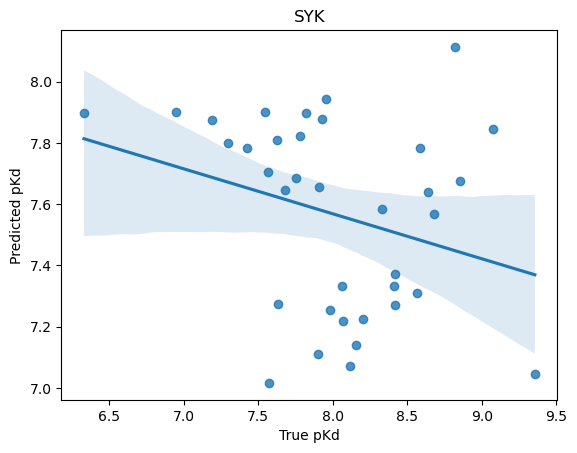

In [56]:
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"SYK")
ax.set_xlabel("True pKd")
ax.set_ylabel("Predicted pKd")